# Разработка модели предсказания инсульта

## Описание Датасета

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Импортируем необходимые для работы библиотеки и взглянем на датасет и информацию по нему

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from optuna.samplers import TPESampler, RandomSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from optuna.integration import CatBoostPruningCallback
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
df.duplicated().sum()

0

In [5]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

(-1.25, 1.25, -1.25, 1.25)

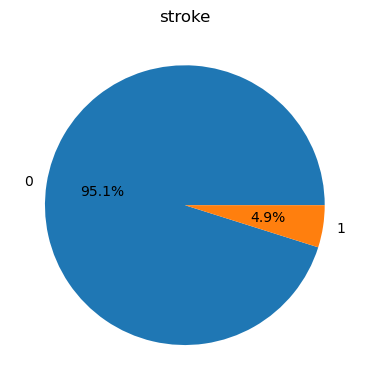

In [6]:
df.stroke.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('stroke')
plt.tight_layout()
plt.axis('off')

## Вывод

Датасет состоит из 5110 строк и 12 столбцов. Дубликатов нет. Пропуски наблюдаются только в столбце bmi. Видим явный дисбаланс классов у целевого признака. Формат столбцов следует поменять в некоторых столбцах. В столбцах age, avg_glucose_level, bmi наблюдаются аномальные значения. Проведем предобработку данных и рассмотрим данные более подробно

## Предобработка данных

Разберем каждый столбец по отдельности

Для начала переведем названия всех столбцов в нижний регистр

In [7]:
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### gender

In [8]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [9]:
df = df[df['gender'] != 'Other']
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [10]:
df['gender'] = df['gender'].replace(('Male', 'Female'), (1, 0))

In [11]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,0,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,1,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,0,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


(-1.25, 1.25, -1.25, 1.25)

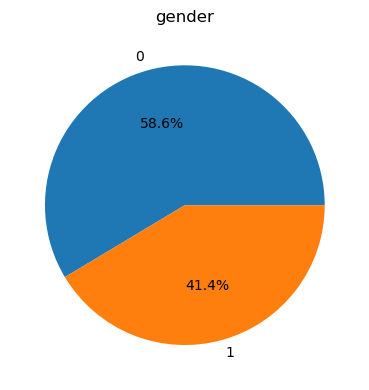

In [12]:
df.gender.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('gender')
plt.tight_layout()
plt.axis('off')

### age

In [13]:
df['age'].describe()

count    5109.000000
mean       43.229986
std        22.613575
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

<Axes: >

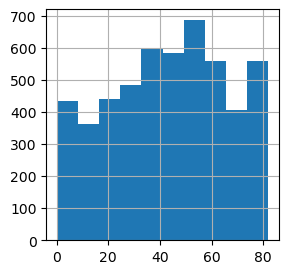

In [14]:
df['age'].hist(figsize=(3, 3))

Среди находящихся в неврологическом отделении можно встретить даже 10–15-летних подростков, хотя чаще сосудистое нарушение наблюдается у людей от 18 до 40 лет. Так как у нас дисбаланс классов и вероятность инсульта у молодых людей достаточно маловероятна, посмотрим наличие инсульта у молодых людей и установим нижний порог

In [15]:
df[(df['age'] <= 15)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,0,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,0,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,30669,1,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,0,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,1,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5089,56714,0,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5094,28048,1,13.00,0,0,No,children,Urban,82.38,24.3,Unknown,0
5095,68598,1,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0
5098,579,1,9.00,0,0,No,children,Urban,71.88,17.5,Unknown,0


Я думаю стоит поставить нижний порог в 15 лет

In [16]:
df = df[df['age'] >= 15]

In [17]:
df['age'].describe()

count    4410.000000
mean       48.993424
std        18.613952
min        15.000000
25%        34.000000
50%        50.000000
75%        63.000000
max        82.000000
Name: age, dtype: float64

### hypertension

In [18]:
df['hypertension'].value_counts()

0    3912
1     498
Name: hypertension, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

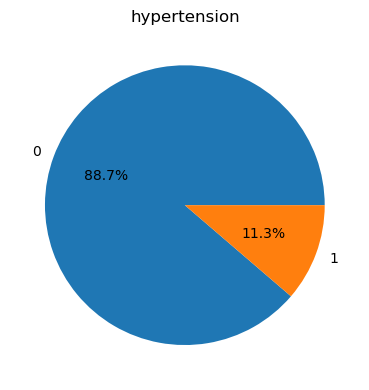

In [19]:
df.hypertension.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('hypertension')
plt.tight_layout()
plt.axis('off')

### heart_disease

In [20]:
df['heart_disease'].value_counts()

0    4135
1     275
Name: heart_disease, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

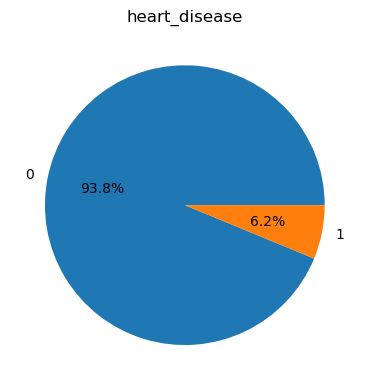

In [21]:
df.heart_disease.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('heart_disease')
plt.tight_layout()
plt.axis('off')

### ever_married

In [22]:
df['ever_married'].value_counts()

Yes    3353
No     1057
Name: ever_married, dtype: int64

Для улучшения работы модели заменим категориальные на количественные признаки

In [23]:
df['ever_married'] = df['ever_married'].replace('Yes', 1)
df['ever_married'] = df['ever_married'].replace('No', 0)
df['ever_married'].value_counts()

1    3353
0    1057
Name: ever_married, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

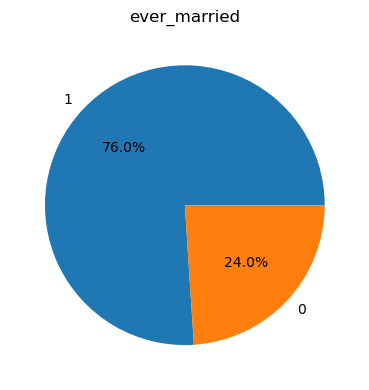

In [24]:
df.ever_married.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('ever_married')
plt.tight_layout()
plt.axis('off')

### work_type

In [25]:
df['work_type'].value_counts()

Private          2895
Self-employed     813
Govt_job          656
children           30
Never_worked       16
Name: work_type, dtype: int64

In [26]:
df['work_type'] = df['work_type'].replace(('Never_worked', 'Private', 'Self-employed', 'Govt_job', 'children'), (0, 1, 2, 3, 4))

In [27]:
df['work_type'].describe()

count    4410.000000
mean        1.498639
std         0.771823
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: work_type, dtype: float64

(-1.25, 1.25, -1.25, 1.25)

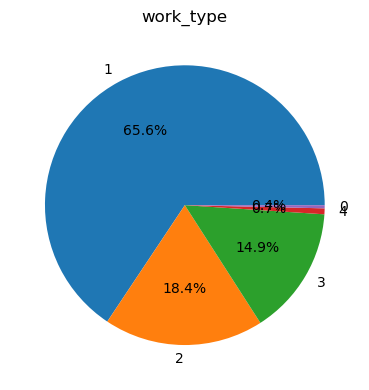

In [28]:
df.work_type.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('work_type')
plt.tight_layout()
plt.axis('off')

### Residence_type

In [29]:
df['residence_type'].value_counts()

Urban    2244
Rural    2166
Name: residence_type, dtype: int64

(-1.25, 1.25, -1.25, 1.25)

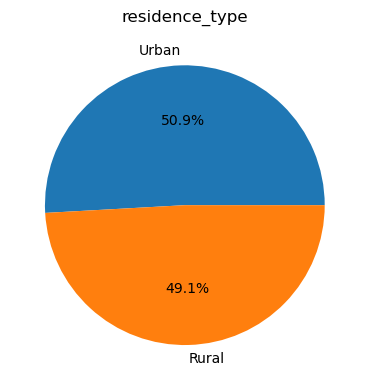

In [30]:
df.residence_type.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('residence_type')
plt.tight_layout()
plt.axis('off')

Чтобы перевести столбец residence_type  в бинарный числовой тип создадим столбец if_urban

In [31]:
df['residence_type'] = df['residence_type'].replace(('Urban', 'Rural'), (1, 0))

In [32]:
df['residence_type'].describe()

count    4410.000000
mean        0.508844
std         0.499978
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: residence_type, dtype: float64

### avg_glucose_level

In [33]:
df['avg_glucose_level'].describe()

count    4410.000000
mean      108.001594
std        47.257134
min        55.120000
25%        77.492500
50%        92.225000
75%       115.820000
max       271.740000
Name: avg_glucose_level, dtype: float64

Cогласно клиническому определению, “нормальный” уровень глюкозы в крови составляет 70-120 мг / дЛ (миллиграмм на децилитр), если вы голодали восемь-двенадцать часов, или 70-160 мг / дЛ, если вы не голодали. Посмотрим количество наблюдений, где avg_glucose_level свыше 160

In [34]:
df[df['avg_glucose_level'] >= 160]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,1,1,228.69,36.6,formerly smoked,1
1,51676,0,61.0,0,0,1,2,0,202.21,NaN,never smoked,1
3,60182,0,49.0,0,0,1,1,1,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,1,2,0,174.12,24.0,never smoked,1
5,56669,1,81.0,0,0,1,1,1,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5062,11184,0,82.0,0,0,1,2,0,211.58,36.9,never smoked,0
5063,68967,1,39.0,0,0,1,1,1,179.38,27.7,Unknown,0
5064,66684,1,70.0,0,0,1,2,0,193.88,24.3,Unknown,0
5076,39935,0,34.0,0,0,1,1,0,174.37,23.0,never smoked,0


Не так много. Если большая часть не переносили инсульт, удалим их из нашего датасета

In [35]:
df[(df['avg_glucose_level'] >= 160)&(df['stroke'] == 0)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
254,32257,0,47.0,0,0,1,1,1,210.95,50.1,Unknown,0
256,41413,0,75.0,0,1,1,2,0,243.53,27.0,never smoked,0
258,28674,0,74.0,1,0,1,2,1,205.84,54.6,never smoked,0
261,63884,0,37.0,0,0,1,1,0,162.96,39.4,never smoked,0
272,4057,1,71.0,0,0,1,1,1,198.21,27.3,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5062,11184,0,82.0,0,0,1,2,0,211.58,36.9,never smoked,0
5063,68967,1,39.0,0,0,1,1,1,179.38,27.7,Unknown,0
5064,66684,1,70.0,0,0,1,2,0,193.88,24.3,Unknown,0
5076,39935,0,34.0,0,0,1,1,0,174.37,23.0,never smoked,0


In [36]:
df = df[df['avg_glucose_level'] <= 160]

<Axes: >

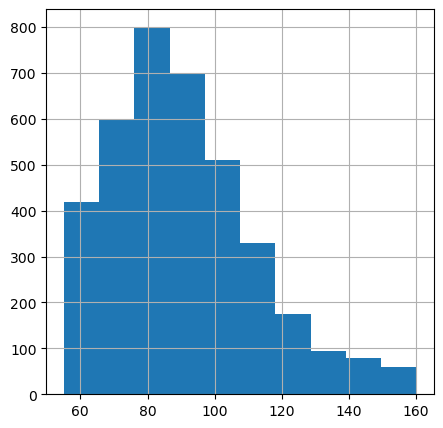

In [37]:
df['avg_glucose_level'].hist(figsize=(5, 5))

Нижний предел оставим как есть

### bmi

In [38]:
df['bmi'].describe()

count    3640.000000
mean       29.827500
std         7.130484
min        11.300000
25%        24.900000
50%        28.700000
75%        33.300000
max        97.600000
Name: bmi, dtype: float64

Наблюдаются слишком высокие и слишком низкие показатели. Исходя из данных из Wikipedia, от 30 лет и выше имеют показатель bmi от 20 и до 42

In [39]:
df = df[(df['bmi'] >= 20)&(df['bmi'] <= 42)]

In [40]:
df['bmi'].describe()

count    3325.000000
mean       29.090827
std         5.184176
min        20.000000
25%        25.000000
50%        28.500000
75%        32.500000
max        42.000000
Name: bmi, dtype: float64

<Axes: >

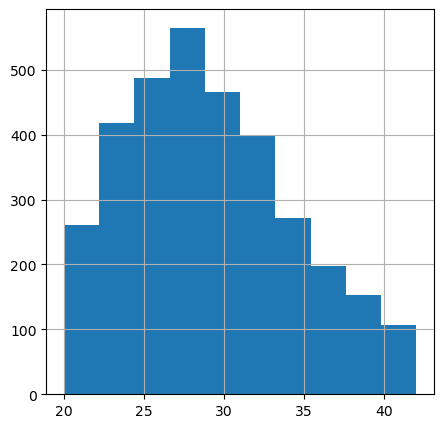

In [41]:
df['bmi'].hist(figsize=(5, 5))

### smoking_status

In [42]:
df['smoking_status'].value_counts()

never smoked       1403
Unknown             731
formerly smoked     607
smokes              584
Name: smoking_status, dtype: int64

Напишем функцию и преобразуем в числовые значения

In [43]:
df['smoking_status'] = df['smoking_status'].replace(('never smoked', 'formerly smoked', 'smokes', 'Unknown'), (0, 1, 2, 3))   

In [44]:
df['smoking_status'].describe()

count    3325.000000
mean        1.193383
std         1.200012
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: smoking_status, dtype: float64

(-1.25, 1.25, -1.25, 1.25)

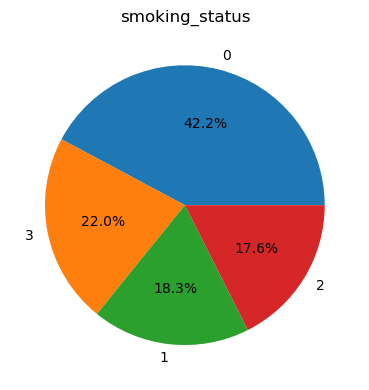

In [45]:
df.smoking_status.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('smoking_status')
plt.tight_layout()
plt.axis('off')

### stroke

(-1.25, 1.25, -1.25, 1.25)

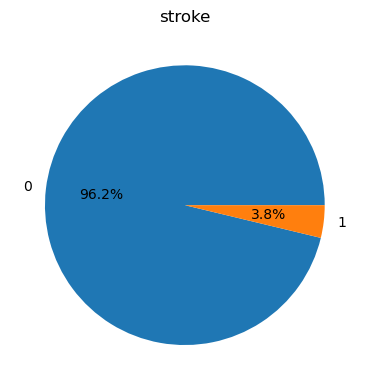

In [46]:
df.stroke.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('stroke')
plt.tight_layout()
plt.axis('off')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 2 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3325 non-null   int64  
 1   gender             3325 non-null   int64  
 2   age                3325 non-null   float64
 3   hypertension       3325 non-null   int64  
 4   heart_disease      3325 non-null   int64  
 5   ever_married       3325 non-null   int64  
 6   work_type          3325 non-null   int64  
 7   residence_type     3325 non-null   int64  
 8   avg_glucose_level  3325 non-null   float64
 9   bmi                3325 non-null   float64
 10  smoking_status     3325 non-null   int64  
 11  stroke             3325 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 337.7 KB


### Вывод по предобработке

В столбце gender убрали 1 строку с показателем other. 

In [48]:
df = df.drop(['id'], axis=1)

## Подготовка к обучению моделей

Разделим наши данные на признаки  целевой признак

In [49]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

In [50]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,1,80.0,0,1,1,1,0,105.92,32.5,0,1
6,1,74.0,1,1,1,1,0,70.09,27.4,0,1
7,0,69.0,0,0,0,1,1,94.39,22.8,0,1
9,0,78.0,0,0,1,1,1,58.57,24.2,3,1
10,0,81.0,1,0,1,1,0,80.43,29.7,0,1


### Борьба с дисбалансом классов

Прежде чем решать проблему дисбаланса классов разделим наш датасет на тренировочну и тестовую выборки

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

Для решения проблемы дисбаланса классов напишем функцию, которая умножит количество наблюдаемых с диагнозом преддиабет, а также функцию, которая уменшит количество здоровых наблюдаемых

In [52]:
def upsample(X_train, y_train, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones]  * repeat * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled

X_upsampled, y_upsampled = upsample(X, y, 4)

In [53]:
def downsample(X_upsampled,y_upsampled, fraction):
    X_zeros = X_upsampled[y_upsampled == 0]
    X_ones = X_upsampled[y_upsampled == 1]
    y_zeros = y_upsampled[y_upsampled == 0]
    y_ones = y_upsampled[y_upsampled == 1]
    
    X_downsampled = pd.concat(
       [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
       [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled= shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_upsampled, y_upsampled, 0.65)

In [54]:
y_downsampled.value_counts()

0    2080
1    2000
Name: stroke, dtype: int64

После устрнения пролемы дисбаланса можно приступить к обучению моделей

In [55]:
X_train = X_downsampled
y_train = y_downsampled

## Обучение моделей

Разделим датасет на обучающую и тестовую выборки

In [56]:
y_train.value_counts()

0    2080
1    2000
Name: stroke, dtype: int64

In [57]:
y_test.value_counts()

0    958
1     40
Name: stroke, dtype: int64

Напишем функцию для получения показателей результатов работы модели

In [58]:
def checkstat (model, X_train, y_train): 
    model.fit(X_train, y_train)
    predicted_test=model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, predicted_test))
    print("F1:", f1_score(y_test, predicted_test))
    print('recall:', recall_score(y_test, predicted_test))
    print('precision:', precision_score(y_test, predicted_test))
    cm = confusion_matrix(y_test, predicted_test, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
    disp.plot()
    plt.show()

## 1.RandomForestClassifier

In [59]:
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=5, class_weight='balanced')
scores = cross_val_score(model_rfc, X_upsampled, y_upsampled, cv = 5, scoring = 'accuracy')
scores

array([0.77307692, 0.83173077, 0.77403846, 0.78173077, 0.78076923])

Accuracy : 0.7535070140280561
F1: 0.2012987012987013
recall: 0.775
precision: 0.11567164179104478


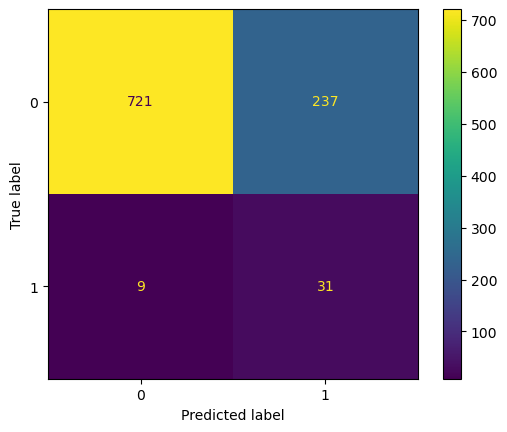

In [60]:
checkstat(model_rfc, X_train, y_train)

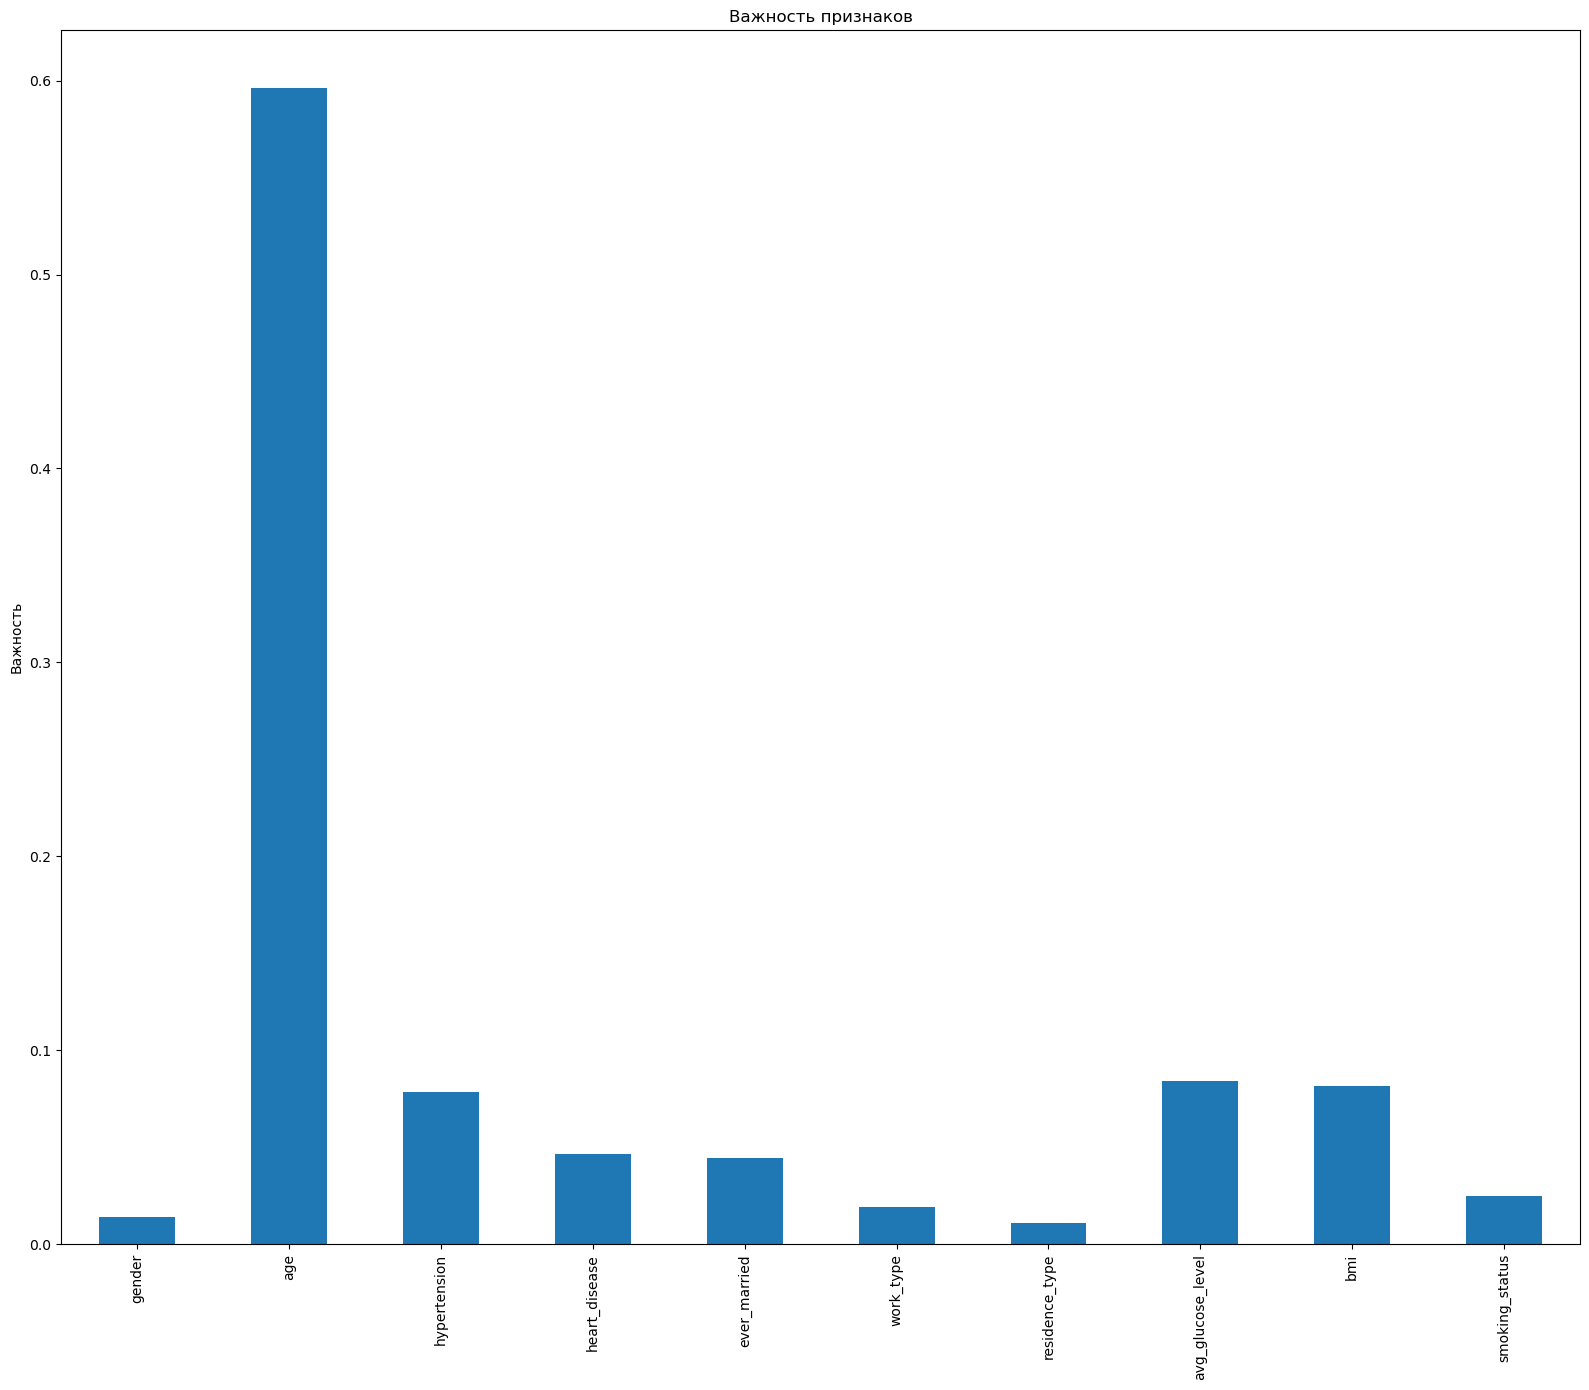

In [61]:
f_imp = pd.Series(model_rfc.feature_importances_,
                         df.drop(['stroke'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

##  2.DecisionTreeClassifier

In [62]:
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=5)
scores = cross_val_score(model_dtc, X_upsampled, y_upsampled, cv = 5, scoring = 'accuracy')
scores

array([0.78076923, 0.79519231, 0.79519231, 0.78942308, 0.81153846])

Accuracy : 0.6983967935871743
F1: 0.20580474934036938
recall: 0.975
precision: 0.11504424778761062


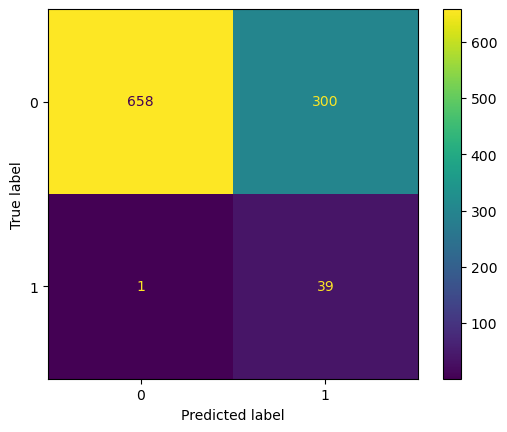

In [63]:
checkstat(model_dtc, X_train, y_train)

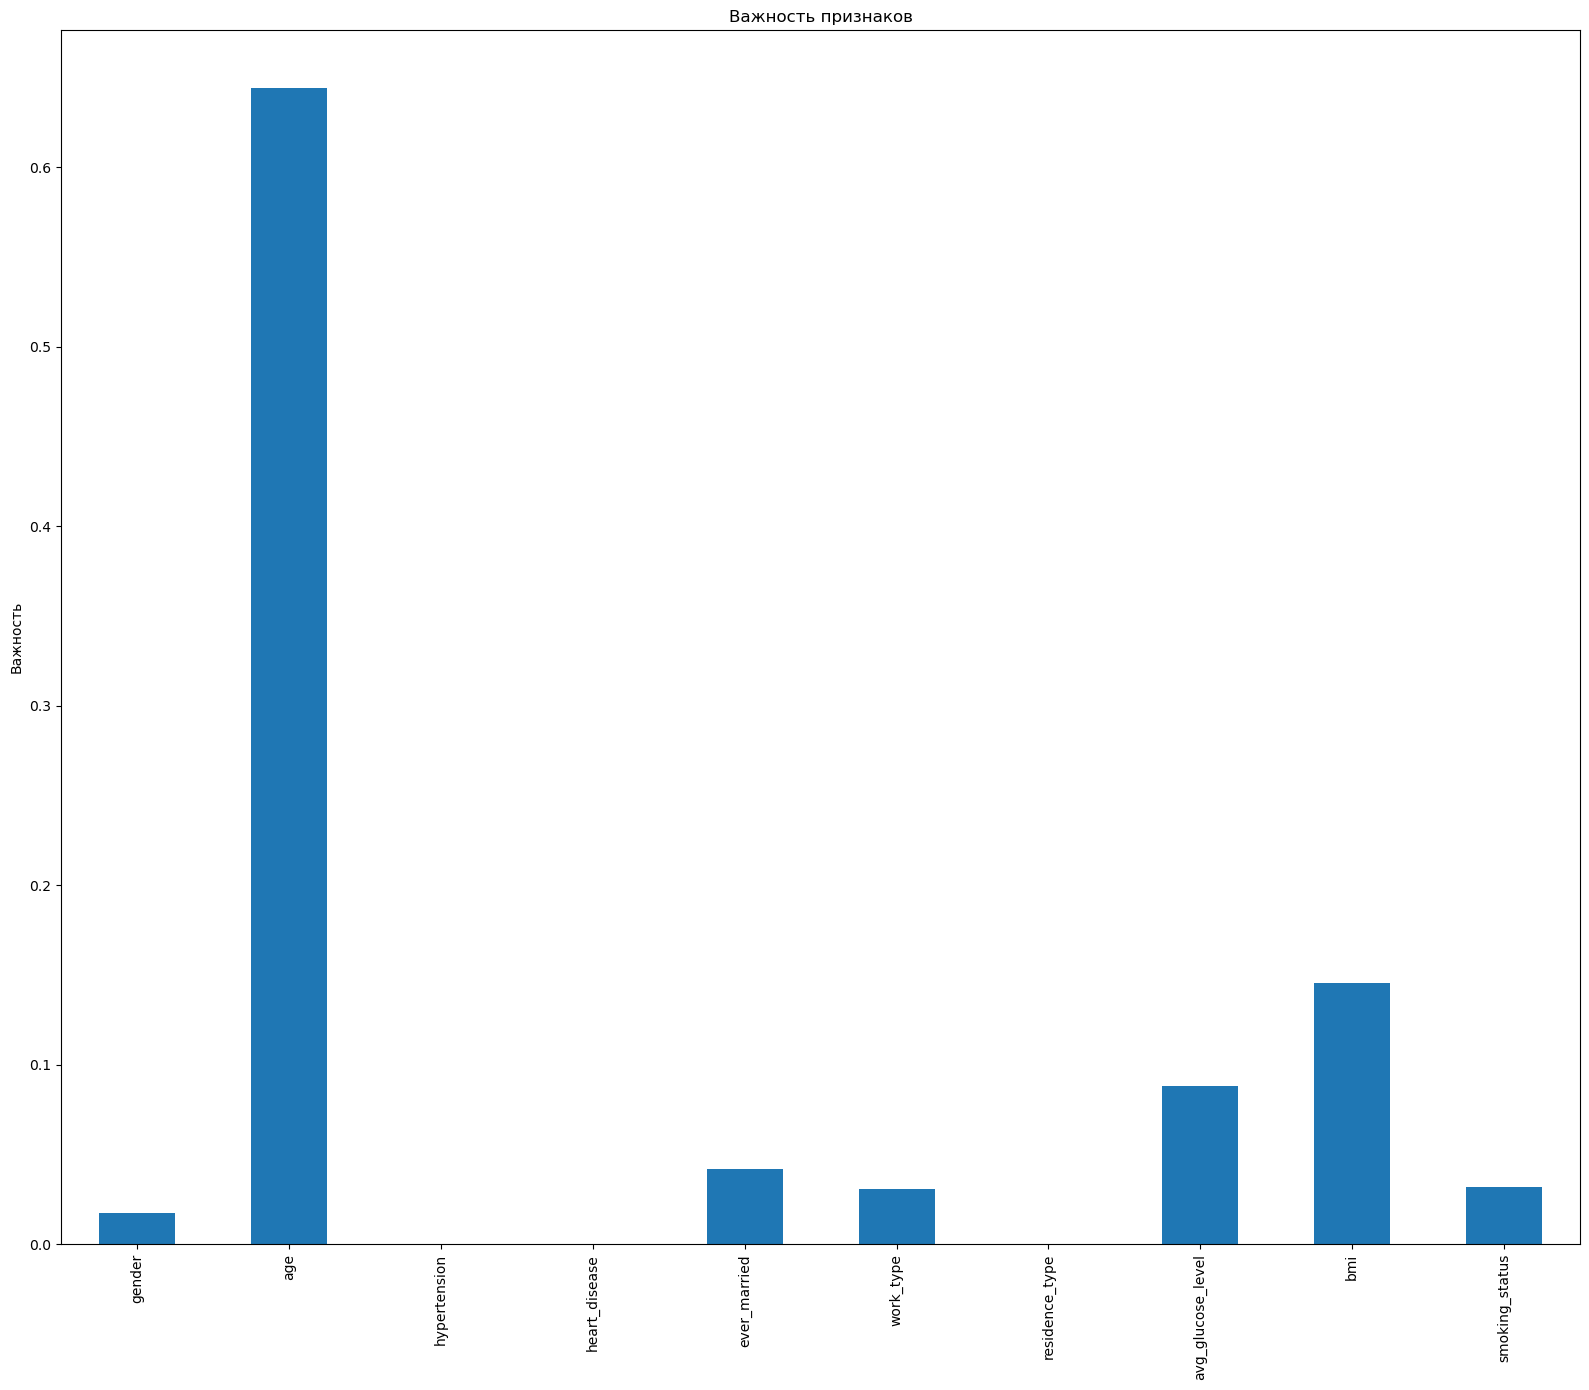

In [64]:
f_imp = pd.Series(model_dtc.feature_importances_,
                         df.drop(['stroke'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## 3.CatBoost

In [65]:
train_pool = Pool (
    X_train,
    y_train

)
test_pool = Pool (
    X_test,
   y_test
)

In [66]:
EVAL = 'TotalF1'

In [67]:
def objective(trial):

   # это гиперпараметры, которые будем проверять. 
    param = {
       # suggest_int и suggest_float - непрерывные переменные. выбирает из диапазона от-до. 
       # можно ставить шаг (как стоит у регуляризации), чтоб он не тыкался +- сотые :)
        'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg':trial.suggest_float('l2_leaf_reg', 2.0, 20.0, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
        'depth': trial.suggest_int('depth', 3, 12),
       
       # suggest_categorical - выбор из списка.
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide', 'Depthwise']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']), 
      
    }
    # эти гиперпараметры тоже подбираем, но отдельно, в зависимости от выбранного bootstrap_type
   # если делать одним куском, то будет падать
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 0.99)
    cat_model = CatBoostClassifier(**param, 
                                   iterations=3000,
                                   random_state=12345,
                                   eval_metric=EVAL,
                                   verbose=0, 
                                   leaf_estimation_method='Newton',
                                #   task_type='GPU',
                                   early_stopping_rounds=120,  
                               #   custom_metric=['AUC', 'NormalizedGini'],
                                   )
    
   # это интеграция. прунер - фиговинка, которая сама прервет эксперимент, если ей что-то не понравится
   # не особо давно добавили и иногда глючит. но с ним лучше
    pruning_callback = CatBoostPruningCallback(trial, EVAL)
   
    cat_model.fit(train_pool, eval_set=test_pool)
   
    pruning_callback.check_pruned()
   
   # результат в процессе оно не печатает, хоть так.
    print(param)
    print(cat_model.best_score_)
    print('________________')
    return cat_model.best_score_['validation'][EVAL]

In [68]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# семплер - что-то типа способа подбора параметров. 
# первые раз 20 лучше запустить RandomSampler(), он работает по принципу RandomizedSearchCV из sklearn
# помогает приблизительно оценить интервалы параметров. потом в функции оптимизации порезать :)
# сам TPESampler рекомендуют запускать под сотню раз. 
sampler = TPESampler(seed=12345) 
# объявление процесса подбора
# для TPESampler используют прунер HyperbandPruner()
# для RandomSampler - прунер MedianPruner()
study = optuna.create_study(study_name="catboost", 
                            direction="maximize",
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=sampler)
# study тут создается новый, а вообще можно его сохранять/загружать, 
# если хочется продолжить подбор на том же наборе данных

In [69]:
# это уже запуск попыток. n_trials количество. можно поставить время timeout
study.optimize(objective, n_trials=5)

{'learning_rate': 0.08503859825373385, 'l2_leaf_reg': 8.0, 'min_data_in_leaf': 100, 'depth': 5, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6816771850580444}
{'learn': {'Logloss': 0.015993364968500675, 'TotalF1': 1.0}, 'validation': {'Logloss': 0.03901205446875506, 'TotalF1': 0.9914166519377673}}
________________
{'learning_rate': 0.05593901428206581, 'l2_leaf_reg': 20.0, 'min_data_in_leaf': 14, 'depth': 4, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7440799587587585}
{'learn': {'Logloss': 0.036997031768488696, 'TotalF1': 0.9987745374203532}, 'validation': {'Logloss': 0.05695694681878714, 'TotalF1': 0.9869649583974536}}
________________
{'learning_rate': 0.043901092488902525, 'l2_leaf_reg': 15.0, 'min_data_in_leaf': 239, 'depth': 6, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25211368943526663}
{'learn': {'Logloss': 0.07531610971276724, 'TotalF1': 0.9884814655469464}, 'validation': {'Logloss': 0.0

In [70]:
# лучшая метрика
study.best_trial.value
# гиперпараметры, для которых она достигнута
study.best_trial.params

{'learning_rate': 0.08503859825373385,
 'l2_leaf_reg': 8.0,
 'min_data_in_leaf': 100,
 'depth': 5,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.6816771850580444}

In [71]:
catboost = CatBoostClassifier(random_state=12345, silent=True)
catboost_params = {
    'learning_rate': 0.08503859825373385,
     'l2_leaf_reg': 8.0,
     'min_data_in_leaf': 100,
     'depth': 5,
     'grow_policy': 'Depthwise',
     'bootstrap_type': 'Bernoulli',
     'bagging_temperature': 0.6816771850580444
}

catboost.fit(train_pool, eval_set=test_pool) 
catboost.best_score_

{'learn': {'Logloss': 0.01605358871759153},
 'validation': {'Logloss': 0.037235723669940594}}

Accuracy : 0.9789579158316634
F1: 0.7920792079207921
recall: 1.0
precision: 0.6557377049180327


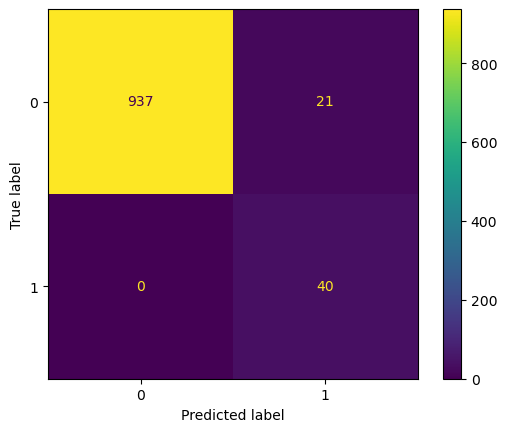

In [72]:
checkstat(catboost, X_train, y_train)

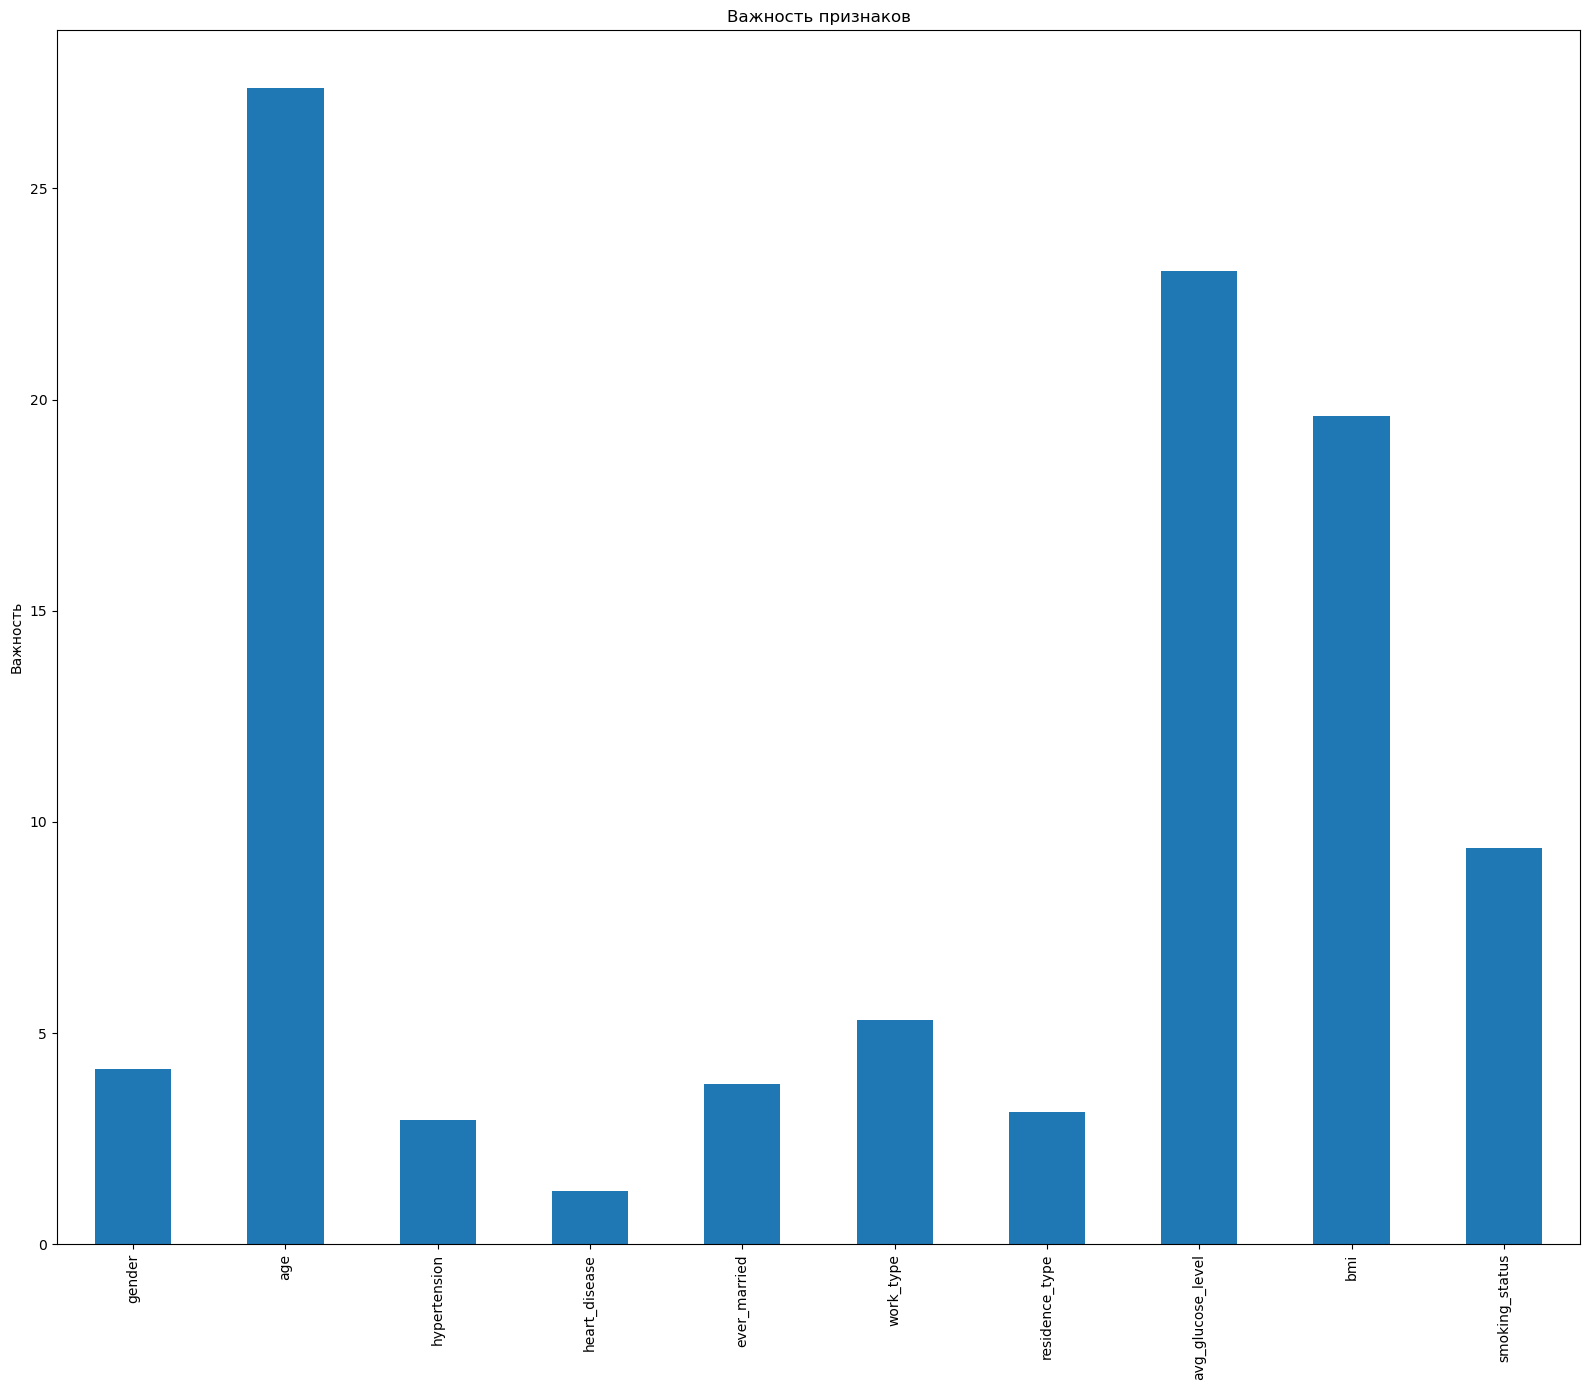

In [73]:
f_imp = pd.Series(catboost.feature_importances_,
                         df.drop(['stroke'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## 4.LGBM

In [74]:
model_lgbm = LGBMClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lgbm, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)', n_scores)

Accuracy: %.3f (%.3f) [0.96813725 0.98529412 0.97303922 0.9754902  0.97303922 0.98284314
 0.97058824 0.9754902  0.9754902  0.98039216 0.96813725 0.97794118
 0.97303922 0.97058824 0.96078431 0.97058824 0.9754902  0.98284314
 0.96568627 0.97794118 0.97303922 0.95833333 0.99264706 0.98039216
 0.98284314 0.96568627 0.97794118 0.97303922 0.9754902  0.96813725]


Accuracy : 0.9819639278557114
F1: 0.8163265306122449
recall: 1.0
precision: 0.6896551724137931


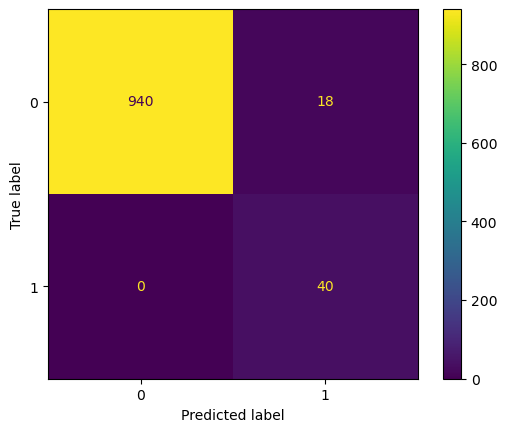

In [75]:
checkstat(model_lgbm, X_train, y_train)

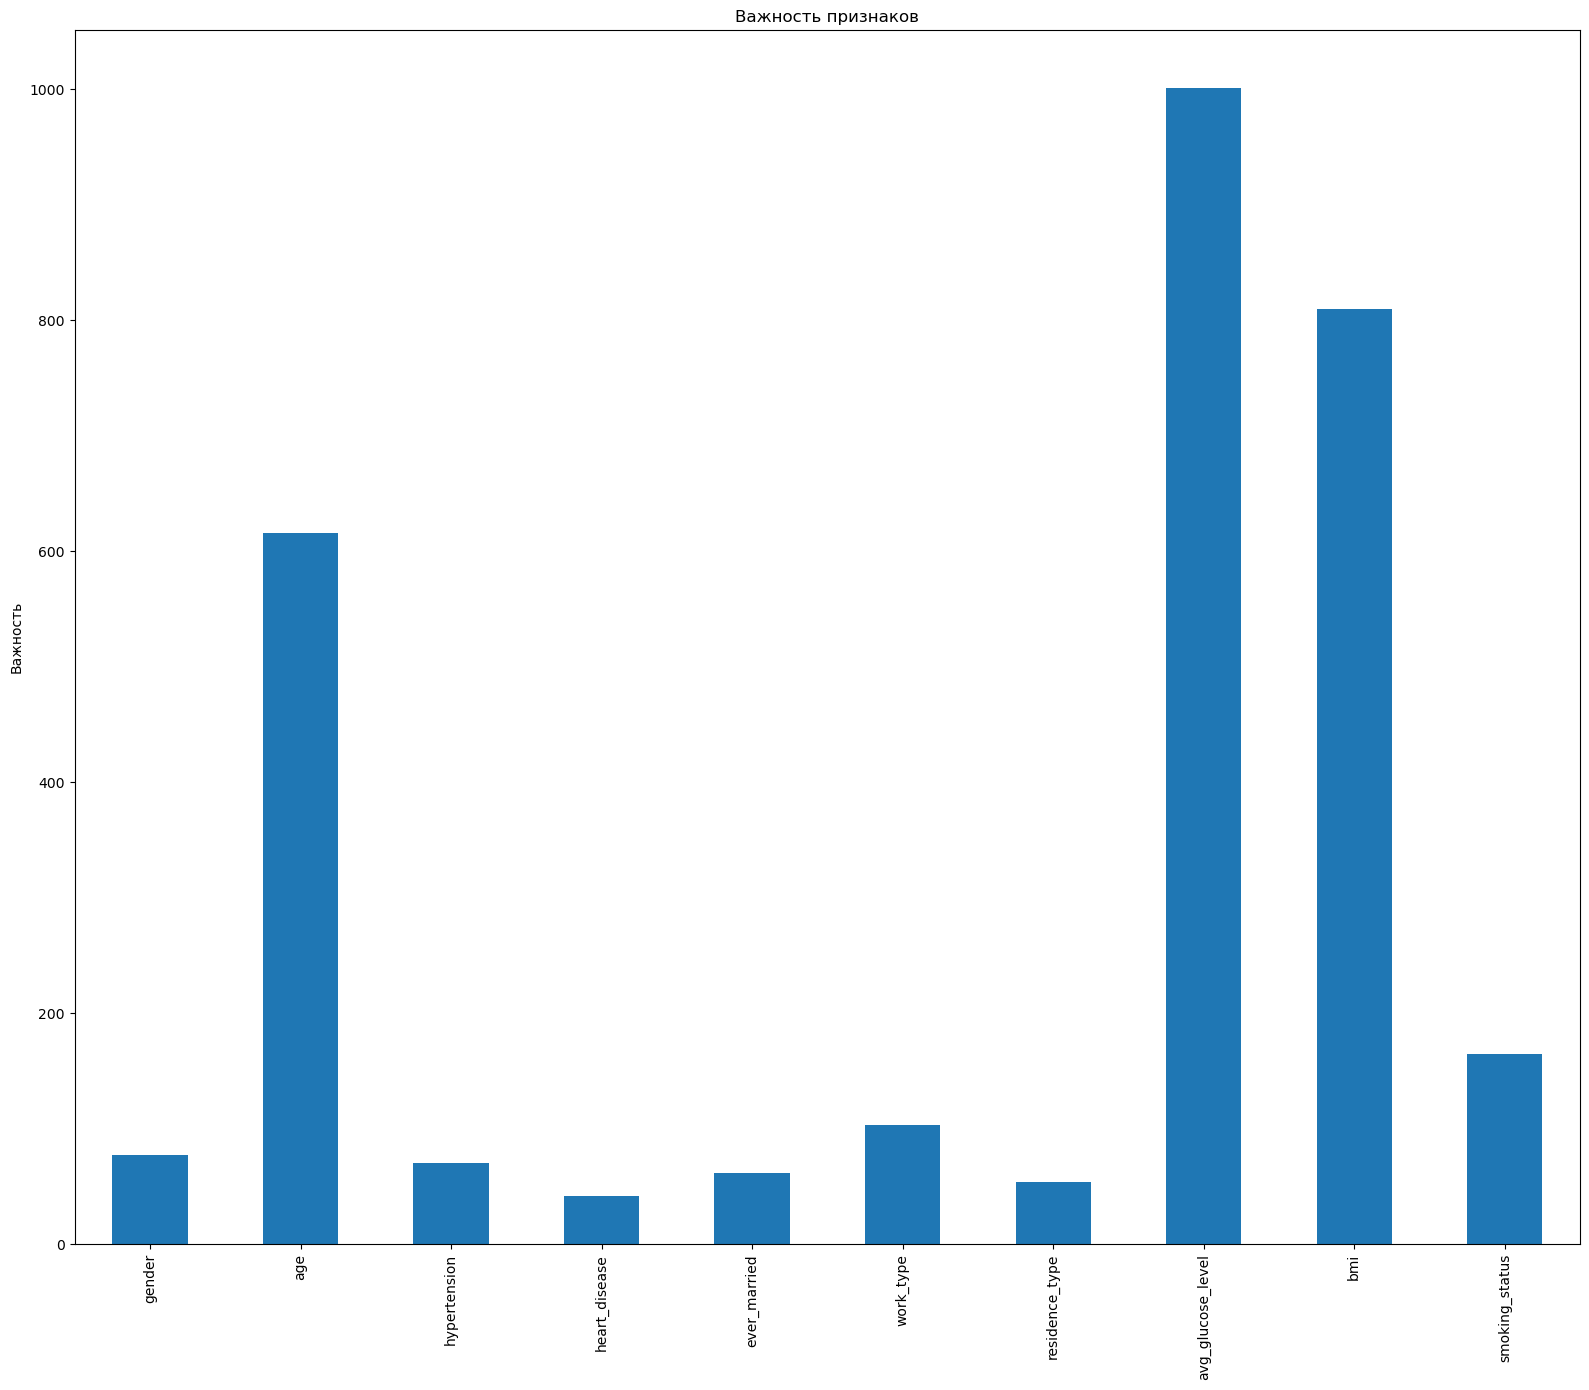

In [76]:
f_imp = pd.Series(model_lgbm.feature_importances_,
                         df.drop(['stroke'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## 5.KNeighborsClassifier

In [77]:
model_KNN = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(model_KNN, X_train, y_train, cv = 5, scoring = 'accuracy')
scores.mean()

0.9205882352941176

Accuracy : 0.8997995991983968
F1: 0.4444444444444445
recall: 1.0
precision: 0.2857142857142857


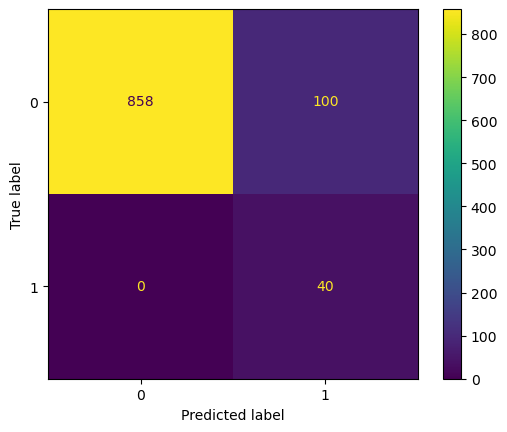

In [78]:
checkstat(model_KNN, X_train, y_train)

# Вывод

В процессе работы была проведена преодобработка данных. Датасет был проверен на пропуски и дубликаты. Был разобран каждый столбец, а именно были преобразованы категориальные признаки в численные, устранены выбросы в данных согласно статистике. Далее для обучения моделей датасет был разделен на обучающую и тестовую выборки. Так как в данных был дисбаланс классов, в тренировочной выборке был исправлен дисбаланс для нормального обучения моделей. В процессе обучения моделей лучший результат показала модель LGBMClassifier